In [1]:
from sklearn.cluster import KMeans
import numpy as np
import scipy
import sys
sys.path.append('../corv/src')

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy.io import fits
from tqdm import tqdm
import pandas as pd
import corv

### Query
from astroquery.sdss import SDSS
from astroquery.gaia import Gaia
from astropy import constants as c
import data_selector as ds

could not find pickled WD models
using local paths
star and exposure catalogs not found! check paths and run make_catalogs() if you want to use sdss functionality. otherwise ignore.


In [2]:
catalog = ds.get_catalog('data/catalog_sdss4.csv')

100%|██████████| 14/14 [00:47<00:00,  3.38s/it]


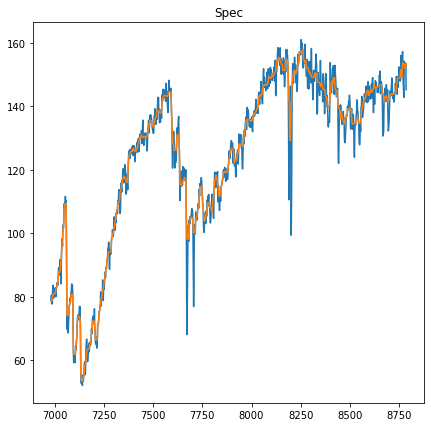

In [3]:
i  = 1
n = 1

a = 2650
b = 3650
line = [8200]

wl_new = np.linspace(4000, 8000, 8000)

wd_pos = [1,2,1,1,2,1,2,2,2,2,2,2,2]
ms_pos = [2,1,2,2,1,2,1,1,1,1,1,1,1]

plt.figure(figsize = (7, 7))
corvmodel = corv.models.make_balmer_model(names = ['a','b'])
params = corvmodel.make_params()
nwl, nfl = corv.models.get_normalized_model(wl_new, corvmodel, params)
#plt.plot(nwl, nfl, 'k.')
params['RV'].set(value = 1000)
#nwl, nfl = corv.models.get_normalized_model(wl_new, corvmodel, params)
#plt.plot(nwl, nfl, 'r.')
plt.plot(catalog['wavelength{}'.format(n)][i][a:b], catalog['flux{}'.format(n)][i][a:b])
plt.plot(catalog['wavelength{}'.format(n)][i][a:b], scipy.ndimage.median_filter(catalog['flux{}'.format(n)][i][a:b], 11))
plt.title('Spec')
ymin, ymax = plt.ylim()
#plt.vlines(line, ymin, ymax, colors='black', ls=':', lw=2, label='vline_single - full height')
plt.show()


 71%|███████▏  | 10/14 [00:57<00:19,  4.95s/it]/home/arseneausm/anaconda3/lib/python3.8/site-packages/corv-0.1-py3.8.egg/corv/utils.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize = figsize)
/home/arseneausm/anaconda3/lib/python3.8/site-packages/corv-0.1-py3.8.egg/corv/utils.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize = figsize)
 79%|███████▊  | 11/14 [00:58<00:11,  3.94s/it]/home/arseneausm/anaconda3/lib/python3.8/site-packages/corv-0.1-py3.8.egg/corv/utils.py:23: RuntimeWarning: More

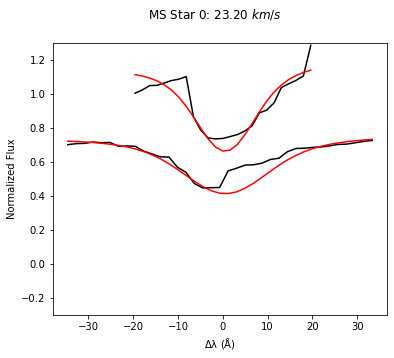

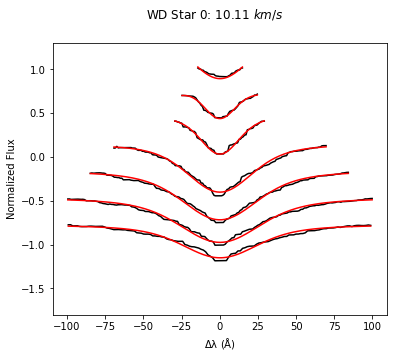

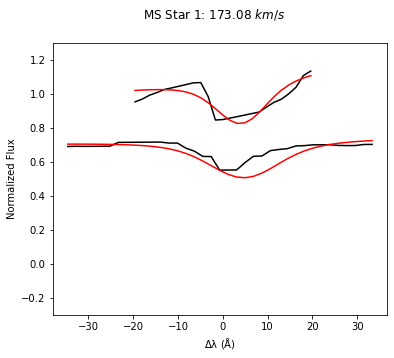

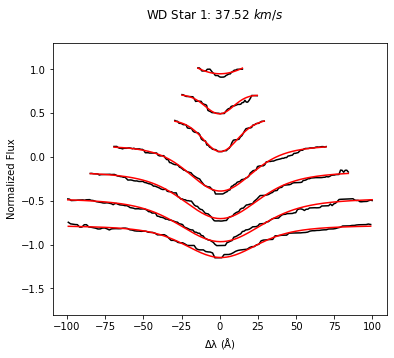

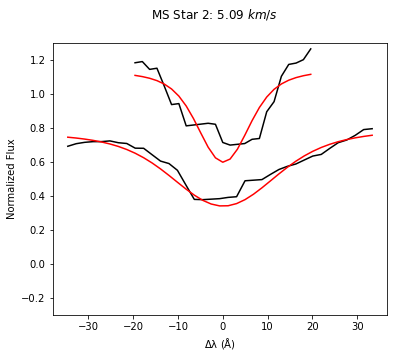

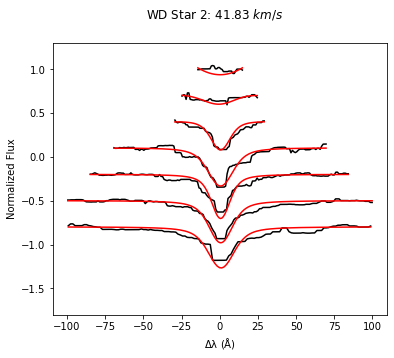

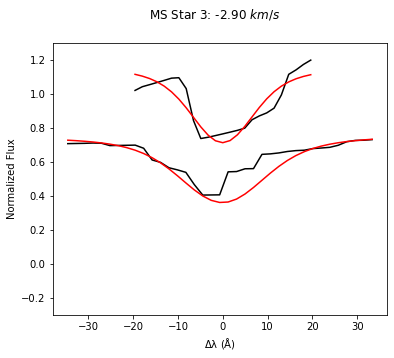

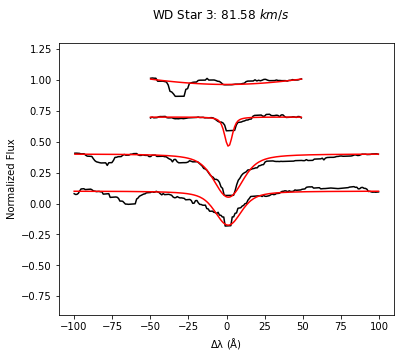

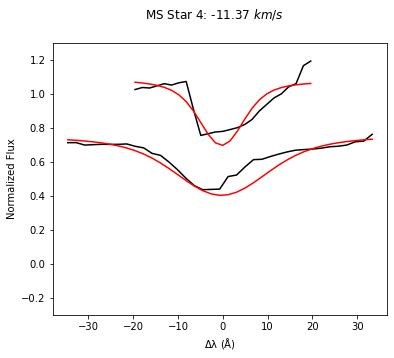

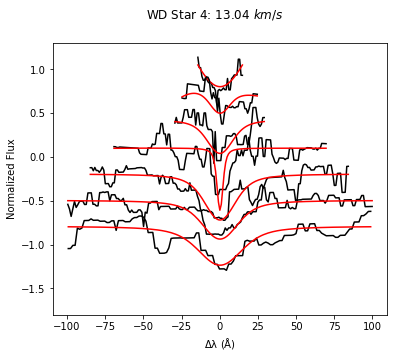

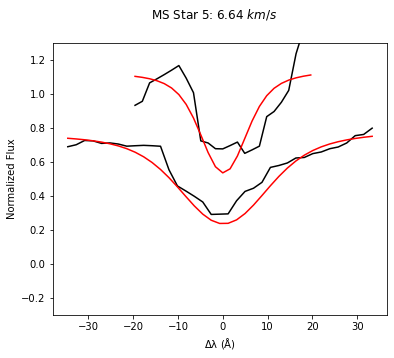

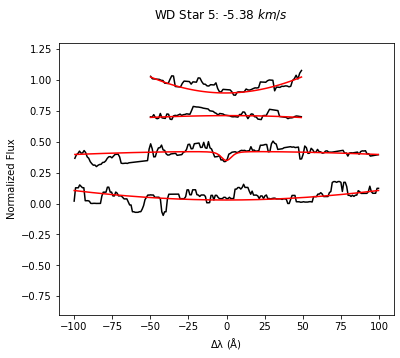

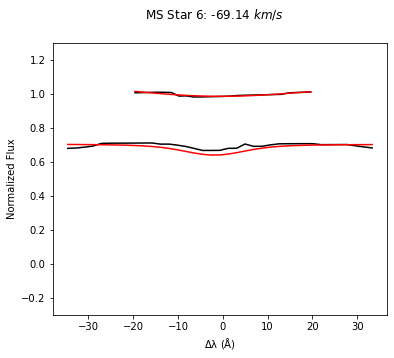

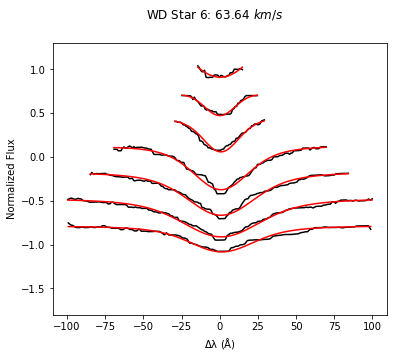

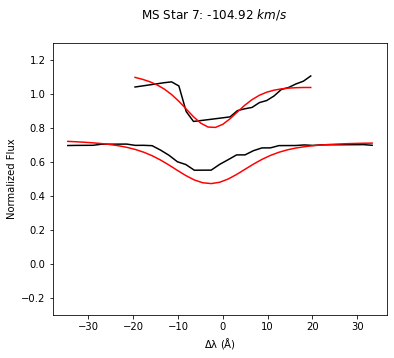

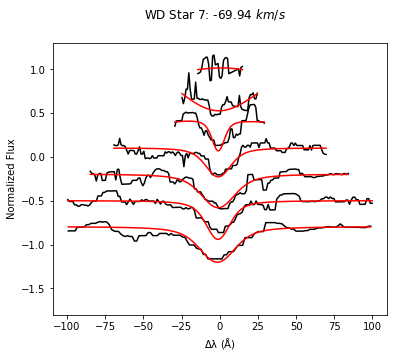

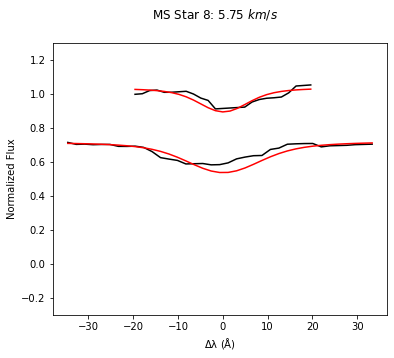

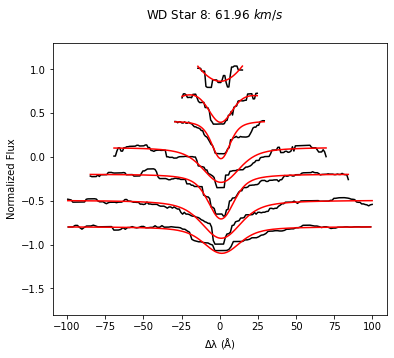

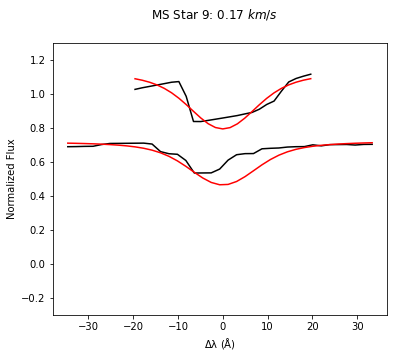

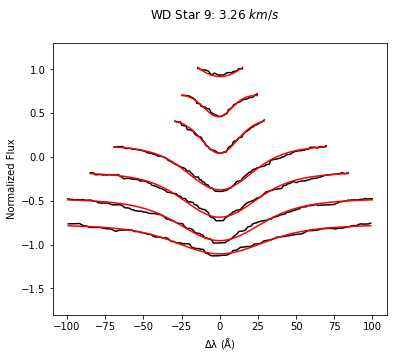

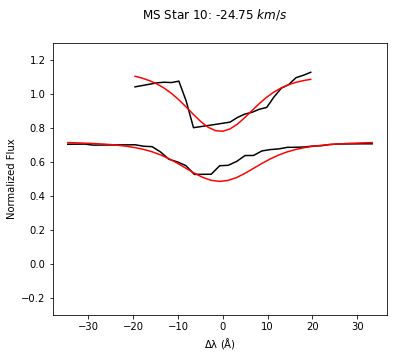

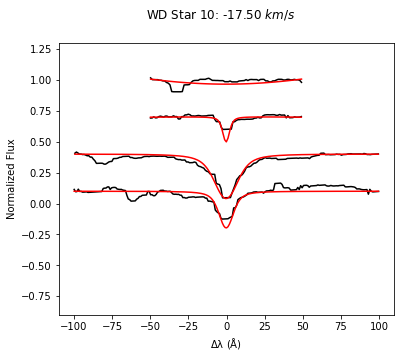

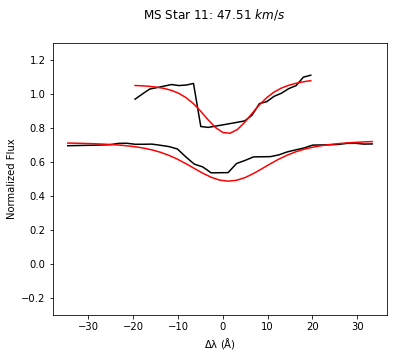

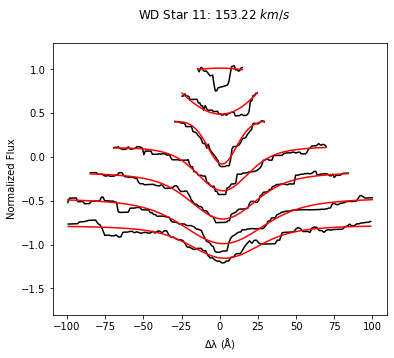

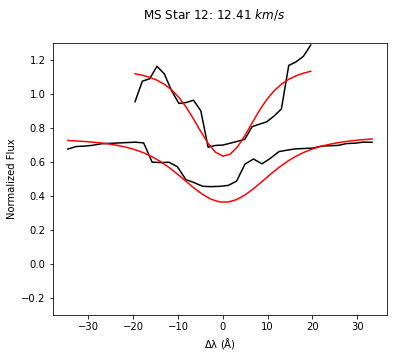

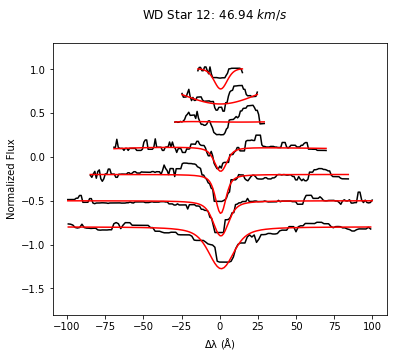

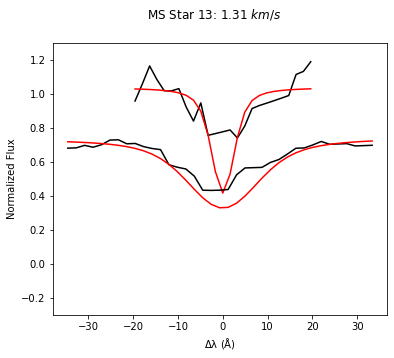

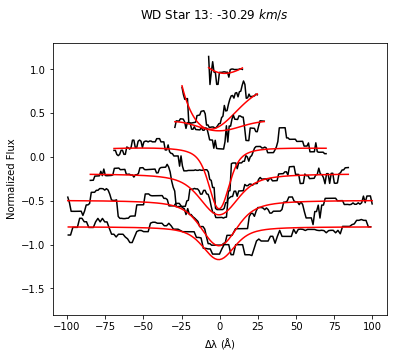

In [4]:
ms_pos = [2,1,2,2,1,2,1,1,1,1,1,1,1,1]
wd_pos = [1,2,1,1,2,1,2,2,2,2,2,2,2,2]

das = [0,1,2,4,6,7,8,9,11,12,13]
dbs = [3,5,10]

msrvs = []
mssterr = []
wdrvs = []
wdsterr = []

for i in tqdm(range(len(ms_pos))):
    #i = 1
    
    mswl = catalog['wavelength{}'.format(ms_pos[i])][i]
    wdwl = catalog['wavelength{}'.format(wd_pos[i])][i]
    msfl = catalog['flux{}'.format(ms_pos[i])][i]
    wdfl = catalog['flux{}'.format(wd_pos[i])][i]
    mspl_fl = scipy.ndimage.median_filter(catalog['flux{}'.format(ms_pos[i])][i], 11)
    wdpl_fl = scipy.ndimage.median_filter(catalog['flux{}'.format(wd_pos[i])][i], 11)
    msivar = catalog['ivar{}'.format(ms_pos[i])][i]
    wdivar = catalog['ivar{}'.format(wd_pos[i])][i]
    
    
    corvmodel_ms = corv.models.make_balmer_model(nvoigt = 1, centres = dict(Ca = 8542 , TiOg = 7095.8, Na2 = 8194.790), 
                                              windows = dict(Ca = 55, TiOg = 20, Na2 = 35),
                                              edges = dict(Ca = 20, TiOg = 10, Na2 = 10),
                                              names = ['TiOg', 'Na2'])
    
    if i in das:
        corvmodel_wd = corv.models.make_balmer_model()
    else:
        corvmodel_wd = corv.models.make_balmer_model(nvoigt = 1, centres = dict(He1 =  5047.738, He2 = 4713.1457, He3 = 4471.48, He4 = 4026.19), 
                                              windows = dict(He1 = 50, He2 = 50, He3 = 100, He4 = 100),
                                              edges = dict(He1 = 10, He2 = 10, He3 = 10, He4 = 10),
                                              names = ['He1', 'He2', 'He3', 'He4'])
    
    msparams = corvmodel_ms.make_params()
    wdparams = corvmodel_wd.make_params()
    
    ms_param_res, ms_rv_res, ms_rv_init = corv.fit.fit_corv(mswl, msfl, msivar, corvmodel_ms)
    wd_param_res, wd_rv_res, wd_rv_init = corv.fit.fit_corv(wdwl, wdfl, wdivar, corvmodel_wd)
    
    #print(param_res.success)
    #print(param_res.redchi)
    
    f = corv.utils.lineplot(mswl, mspl_fl, msivar, corvmodel_ms, ms_param_res.params, printparams = False)
    f.suptitle(r"MS Star %d: %2.2f $km/s$" % (i, ms_param_res.params['RV'].value))
    f.savefig('spectra/sdss4/ms_corvfits/fit{}.jpg'.format(i))
    
    f = corv.utils.lineplot(wdwl, wdpl_fl, wdivar, corvmodel_wd, wd_param_res.params, printparams = False)
    f.suptitle(r"WD Star %d: %2.2f $km/s$" % (i, wd_param_res.params['RV'].value))
    f.savefig('spectra/sdss4/wd_corvfits/fit{}.jpg'.format(i))
    
    #print(param_res.success)
    msrvs.append(ms_param_res.params['RV'].value)
    mssterr.append(0)
    wdrvs.append(wd_param_res.params['RV'].value)
    wdsterr.append(0)
    
   # i=0
    
    #print('MS: ' + str(msrvs[i]) + ' +/- ' + str(mssterr[i]))
    #print('WD: ' + str(wdrvs[i]) + ' +/- ' + str(wdsterr[i]))
    #print('GR: ' + str(wdrvs[i] - msrvs[i]))
    
    #break
    


In [5]:
print(msrvs)

[23.195452895776725, 173.08494185890595, 5.088849002219831, -2.9016910216287215, -11.370593484371057, 6.640129227528178, -69.14403488822018, -104.91651362690436, 5.751936483264217, 0.1738883802536293, -24.752101396590206, 47.508699729438376, 12.410841079194597, 1.3102312465312025]


In [6]:
print(wdrvs)

[10.114031992783566, 37.51958724802989, 41.83194191480288, 81.5835167694222, 13.044407506482912, -5.37902393648028, 63.639202790918716, -69.93582866324414, 61.959140044916694, 3.2621298633212064, -17.4977887592986, 153.2179410364065, 46.94300499191604, -30.29175281713833]


In [7]:
print(np.array(wdrvs) - np.array(msrvs))

[ -13.0814209  -135.56535461   36.74309291   84.48520779   24.41500099
  -12.01915316  132.78323768   34.98068496   56.20720356    3.08824148
    7.25431264  105.70924131   34.53216391  -31.60198406]
